# Renewable Energy Systems (RES) project

In this exercise, the capacity and dispatch of generators in the power system of one country are optimized.

First, the country is modelled as a single node. 

In [89]:
import pypsa
import pandas as pd

We start by creating the network.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Spain (ESP), and add one node to the network.

In [90]:
network = pypsa.Network()
hours_in_2015=pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z',freq='H')
network.set_snapshots(hours_in_2015)

network.add("Bus","electricity bus")

The load is represented by the historical electricity demand in 2015 with hourly resolution. 

The file with historical hourly data for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD).

In [91]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv',sep=';',index_col=0) # in MWh
df_elec['ESP']

# add load to the bus
network.add("Load","load", bus="electricity bus", p_set=df_elec['ESP'])

In the optimisation, we will minimise the anualised system costs.

We will need to anualise the cost of every generator, we build a function to do it.

In [92]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators. 

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select optimal for PV and onshore for wind). 

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in the paper https://arxiv.org/pdf/1906.06936.pdf

In [93]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind=df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000,
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv',sep=';',index_col=0)
CF_solar=df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000,
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

We solve the linear optimal power flow (lopf) using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [94]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35044_copy
  Lower bound: 12852241324.560421
  Upper bound: 12852241324.560421
  Number of objectives: 1
  Number of constraints: 70081
  Number of variables: 35044
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 35044
  Number of nonzeros: 109681
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

('ok', 'optimal')

The result ('ok', 'optimal') indicates that the optimizer has found an optimal solution. 

The total cost can be read from the network objetive.

In [100]:
print(network.objective/1000000) #in 10^6 #
print(network.objective/network.loads_t.p.sum()) # €/MWh

12852.24132456042
load    51.719905
dtype: float64


The optimal capacity for every generator can be shown.

In [101]:
network.generators.p_nom_opt

onshorewind    48793.402778
solar          38809.596688
OCGT           36924.371528
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electriticy demand.

We can also plot the electricity mix.

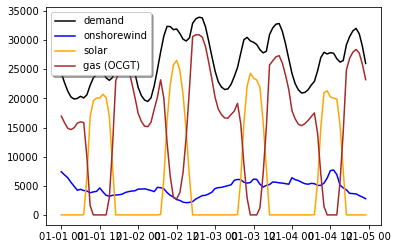

In [103]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

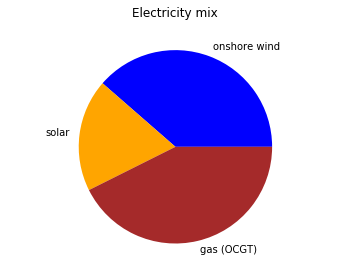

In [106]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

We can add a global CO2 constraint and solve again.

In [109]:
co2_limit=4000000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35044_copy
  Lower bound: 18448555645.360535
  Upper bound: 18448555645.360535
  Number of objectives: 1
  Number of constraints: 70082
  Number of variables: 35044
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 35044
  Number of nonzeros: 118441
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

('ok', 'optimal')

In [110]:
network.generators.p_nom_opt

onshorewind    190147.670808
solar           32683.511351
OCGT            33249.160559
Name: p_nom_opt, dtype: float64

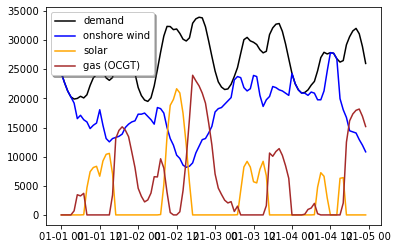

In [111]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

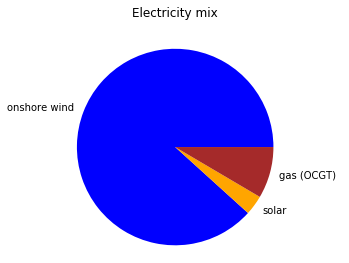

In [112]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## PROJECT DESCRIPTION

Based on the previous example you are asked to carry out the following exercise:

A. Choose a different country and calculate the optimal capacities for renewable and non-renewable generators. You are free to add new technologies but remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. 

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint.

C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability for every generator using different weather data. 

D. Add some storage technologies and investigate how it behaves. 

C. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimase the whole system. You can also included fixed interconnection capacities or cooptimise them with the generators capacities. 

F. Add other sectors such as heating 

TODO: Add p_nom_max in generators, add Kirchhoff formulation